LSTM (Long short-term memory) model


In [18]:
import yfinance as yf
import pandas as pd
import requests
from io import StringIO
import time

from tensorflow.python.keras.utils.version_utils import callbacks
from tqdm import tqdm
import numpy as np

# scrape the S&P 500 from wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(wiki_url)

# wrap the text in StringIO object to prevent Pandas "future warning"
wiki_tables = pd.read_html(StringIO(response.text))

# the first table is the relevant one
sp500_table = wiki_tables[0]
print("SP500 table shape:", sp500_table.shape)

SP500 table shape: (503, 8)


In [19]:
# Notice we also get the sector and sub-industry
print(sp500_table.head())

  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  


In [20]:
# Get the stock tickers.
ticker_list = sp500_table["Symbol"].tolist()
# Replace dots with dashes to be compatible with Yahoo Finance API
ticker_list = [ticker.replace(".", "-") for ticker in ticker_list]
# For testing, only use 50 tickers:
ticker_list = ticker_list[:50]

# Define a 5-year window
start_date = "2020-01-01"
end_date = "2025-01-01"


def get_stock_data(ticker, start_date=start_date, end_date=end_date):
    """Gets the historic data for a stock based on the ticker and a date range."""
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    # Remove the ticker column (the ticker will be found in the filename)
    temp_df.columns = temp_df.columns.droplevel(1)
    return temp_df


# List of dataframes, each being stock data
all_stock_data = []

# Use tqdm for a progress bar
for ticker in tqdm(ticker_list, desc="Downloading stocks..."):
    temp_df = get_stock_data(ticker)
    # Check if empty or full of NaN (happens with API rate limits)
    if temp_df.empty or temp_df.isna().all().all():
        print(f"Error getting {ticker}")
    else:
        all_stock_data.append(temp_df)
    # To prevent too many API calls
    time.sleep(1)

print(f"Collected {len(all_stock_data)} stocks")

Collected 50 stocks


In [21]:
# Compute the RSI and add it as a column.
def compute_rsi(series, window=14):
    """Computes the Relative Strength Index (RSI) for a given series."""
    diff_series = series.diff()
    # Gains and losses
    gains = diff_series.apply(lambda x: x if x > 0 else 0)
    losses = diff_series.apply(lambda x: -x if x < 0 else 0)
    # Average gain and loss over a sliding window
    avg_gain = gains.rolling(window=window, min_periods=window).mean()
    avg_loss = losses.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def classify_rsi(rsi):
    """Classifies an RSI value into Overbought, Oversold or Neutral."""
    if np.isnan(rsi):
        return np.nan
    if rsi > 70:
        return "Overbought"
    elif rsi < 30:
        return "Oversold"
    else:
        return "Neutral"


# Compute the RSI and RSI class for all stocks
for stock_data, ticker in zip(all_stock_data, ticker_list):
    stock_data['RSI'] = compute_rsi(stock_data['Close'])
    stock_data['RSI_class'] = stock_data['RSI'].apply(classify_rsi)

# Example for one stock (e.g., $MMM if it is first in the list)
print("Example data for " + ticker_list[0])
print(all_stock_data[0].head(20))

Example data for MMM
Price            Close        High         Low        Open    Volume  \
Date                                                                   
2020-01-02  122.357445  122.364243  120.413315  120.780389   4307633   
2020-01-03  121.303833  121.446581  119.386895  120.331774   2950412   
2020-01-06  121.419327  121.480510  119.876263  120.420076   2389608   
2020-01-07  120.929947  121.344608  120.195798  121.188251   2598908   
2020-01-08  122.785652  123.377052  120.759958  120.997880   3298927   
2020-01-09  123.173157  123.438259  122.194300  123.383886   3284575   
2020-01-10  122.676933  123.839327  122.452607  123.451858   2516145   
2020-01-13  122.982849  123.873343  122.602178  122.996445   2500597   
2020-01-14  123.288719  124.090837  122.500198  122.982828   3481795   
2020-01-15  122.207870  123.621783  121.800020  123.322690   2968711   
2020-01-16  123.043991  123.173143  122.146700  122.819665   2571280   
2020-01-17  123.275093  123.818906  122.833

In [22]:
# Implement logarithmic returns and volatility as new columns.
def compute_log_return(series):
    """Computes the logarithmic return of a series."""
    day_offset = series.shift(1)
    return np.log(series / day_offset)


def compute_volatility(series, window=14):
    """Computes the volatility of a logarithmic return series using a rolling window."""
    volatility = series.rolling(window=window, min_periods=window).std()
    return volatility


# Compute log returns and volatility for all stocks
for stock_data, ticker in zip(all_stock_data, ticker_list):
    stock_data['Log_return'] = compute_log_return(stock_data['Close'])
    stock_data['Volatility'] = compute_volatility(stock_data['Log_return'])

print("Example data for " + ticker_list[0])
print(all_stock_data[0].head(20))

Example data for MMM
Price            Close        High         Low        Open    Volume  \
Date                                                                   
2020-01-02  122.357445  122.364243  120.413315  120.780389   4307633   
2020-01-03  121.303833  121.446581  119.386895  120.331774   2950412   
2020-01-06  121.419327  121.480510  119.876263  120.420076   2389608   
2020-01-07  120.929947  121.344608  120.195798  121.188251   2598908   
2020-01-08  122.785652  123.377052  120.759958  120.997880   3298927   
2020-01-09  123.173157  123.438259  122.194300  123.383886   3284575   
2020-01-10  122.676933  123.839327  122.452607  123.451858   2516145   
2020-01-13  122.982849  123.873343  122.602178  122.996445   2500597   
2020-01-14  123.288719  124.090837  122.500198  122.982828   3481795   
2020-01-15  122.207870  123.621783  121.800020  123.322690   2968711   
2020-01-16  123.043991  123.173143  122.146700  122.819665   2571280   
2020-01-17  123.275093  123.818906  122.833

### Earnings Data and Visualization
In
the
next
section, earnings
data is added and a
couple
of
visualizations
are
produced.

In [23]:
import requests

# Replace with your actual Alpha Vantage API key
API_KEY = "GDEK4PY7POOU14P5"
ticker = "AAPL"

url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={API_KEY}"
response = requests.get(url)
data = response.json()

# Example: Print the first few quarterly earnings reports
earnings_history = data.get("quarterlyEarnings", [])
print([report for report in earnings_history[:5]])

[{'fiscalDateEnding': '2024-12-31', 'reportedDate': '2025-01-30', 'reportedEPS': '2.4', 'estimatedEPS': '2.36', 'surprise': '0.04', 'surprisePercentage': '1.6949', 'reportTime': 'post-market'}, {'fiscalDateEnding': '2024-09-30', 'reportedDate': '2024-10-31', 'reportedEPS': '1.64', 'estimatedEPS': '1.6', 'surprise': '0.04', 'surprisePercentage': '2.5', 'reportTime': 'post-market'}, {'fiscalDateEnding': '2024-06-30', 'reportedDate': '2024-08-01', 'reportedEPS': '1.4', 'estimatedEPS': '1.35', 'surprise': '0.05', 'surprisePercentage': '3.7037', 'reportTime': 'post-market'}, {'fiscalDateEnding': '2024-03-31', 'reportedDate': '2024-05-02', 'reportedEPS': '1.53', 'estimatedEPS': '1.5', 'surprise': '0.03', 'surprisePercentage': '2', 'reportTime': 'post-market'}, {'fiscalDateEnding': '2023-12-31', 'reportedDate': '2024-02-01', 'reportedEPS': '2.18', 'estimatedEPS': '2.1', 'surprise': '0.08', 'surprisePercentage': '3.8095', 'reportTime': 'post-market'}]


In [24]:
def get_earnings_data(ticker):
    """Gets the earnings data for a ticker from Alpha Vantage."""
    url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    if "quarterlyEarnings" not in data:
        return None
    earnings_df = pd.DataFrame(data['quarterlyEarnings'])
    earnings_df['reportedDate'] = pd.to_datetime(earnings_df['reportedDate'])
    earnings_df['reportedEPS'] = pd.to_numeric(earnings_df['reportedEPS'])
    return earnings_df


def add_earnings_info(stock_df, earnings_df):
    """Adds earnings info (days to next earnings and last reported EPS) to the stock dataframe."""
    if earnings_df is None:
        print("Error: Earnings data is None. Check retrieval process.")
        return None

    stock_df['Days_to_Earnings'] = np.nan
    stock_df['Last_EPS'] = np.nan
    earnings_dates = earnings_df['reportedDate'].sort_values().tolist()

    for current_date, row in stock_df.iterrows():
        future_earnings = [date for date in earnings_dates if date >= current_date]
        past_earnings = [date for date in earnings_dates if date < current_date]
        if future_earnings:
            next_earnings_date = future_earnings[0]
            days_to_earnings = (next_earnings_date - current_date).days
            stock_df.at[current_date, 'Days_to_Earnings'] = days_to_earnings
        if past_earnings:
            last_earnings_row = earnings_df.loc[earnings_df['reportedDate'] == past_earnings[-1]]
            last_eps = last_earnings_row['reportedEPS'].values[0]
            stock_df.at[current_date, 'Last_EPS'] = last_eps


# Example: add earnings info for the first stock
add_earnings_info(all_stock_data[0], get_earnings_data(ticker_list[0]))
print(all_stock_data[0][10:25])

Price            Close        High         Low        Open    Volume  \
Date                                                                   
2020-01-16  123.043991  123.173143  122.146700  122.819665   2571280   
2020-01-17  123.275093  123.818906  122.833252  123.037183   4413360   
2020-01-21  121.942772  123.655777  121.426151  123.614989   4027769   
2020-01-22  121.018295  122.744897  120.916336  122.024357   2894559   
2020-01-23  120.821167  121.296999  119.903481  120.365717   2820646   
2020-01-24  121.099899  122.228303  120.678452  121.331023   3161148   
2020-01-27  119.386848  122.758474  119.325665  122.262247   5216234   
2020-01-28  112.555237  117.150440  112.194973  116.851347  10669157   
2020-01-29  110.121689  113.160231  109.802201  113.078653   6391304   
2020-01-30  110.468369  110.556732  107.919255  109.441925   5211092   
2020-01-31  107.851265  110.563521  107.558970  110.121680   6865399   
2020-02-03  106.444176  108.972895  106.301415  108.782560   469

In [25]:
# Run earnings data addition for every company (using tqdm to track progress)
for stock_data, ticker in tqdm(zip(all_stock_data, ticker_list), total=len(all_stock_data)):
    add_earnings_info(stock_data, get_earnings_data(ticker))
    time.sleep(1)

100%|██████████| 50/50 [01:12<00:00,  1.46s/it]


In [26]:
# Test earnings info with the last stock
print(f"Data for {ticker_list[49]}:")
print(all_stock_data[49])

Data for ADSK:
Price            Close        High         Low        Open   Volume  \
Date                                                                  
2020-01-02  187.830002  187.889999  181.880005  184.210007  1515000   
2020-01-03  184.949997  186.410004  183.779999  184.490005   737900   
2020-01-06  187.119995  187.250000  183.160004  183.779999  1021900   
2020-01-07  187.500000  188.169998  185.100006  186.130005   897200   
2020-01-08  189.949997  190.500000  187.029999  188.220001  1314800   
...                ...         ...         ...         ...      ...   
2024-12-24  301.230011  301.230011  296.679993  297.549988   560000   
2024-12-26  300.279999  301.730011  299.429993  299.429993   646800   
2024-12-27  297.589996  298.839996  294.570007  298.640015  1041600   
2024-12-30  297.529999  298.920013  291.739990  292.989990  1191200   
2024-12-31  295.570007  298.549988  294.970001  298.549988   708100   

Price             RSI RSI_class  Log_return  Volatility  Days

### Visualization of Earnings vs. Volatility
Below, an
example
plot is created
to
compare
how
the
number
of
days
to
the
next
earnings
report
relates
to
logarithmic
volatility.

Available columns in stock_data: ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'RSI_class', 'Log_return', 'Volatility', 'Days_to_Earnings', 'Last_EPS']


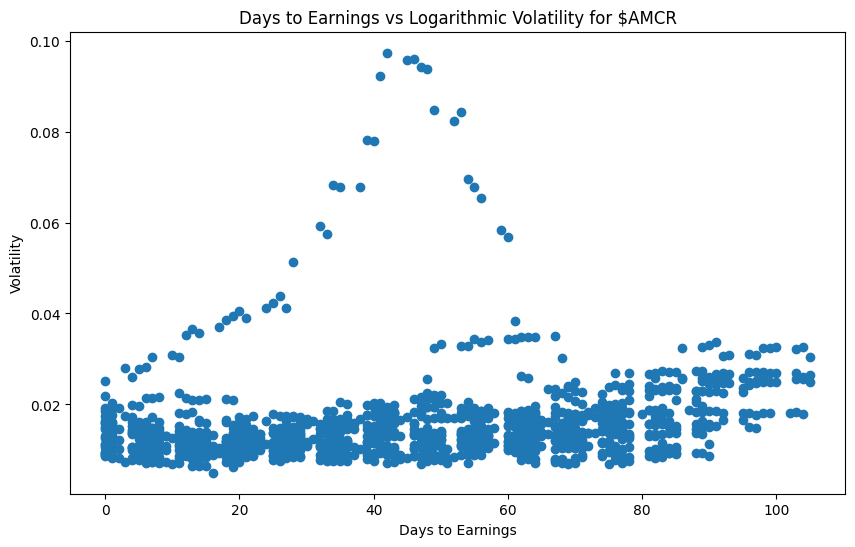

In [27]:
import matplotlib.pyplot as plt

# Assume 'all_stock_data' is a list of pandas DataFrames and 'ticker_list' is a list of ticker names
stock_data = all_stock_data[23]

# Print out the list of available columns for debugging
print("Available columns in stock_data:", stock_data.columns.tolist())

# Check if both required columns exist
required_columns = ['Days_to_Earnings', 'Volatility']
missing_columns = [col for col in required_columns if col not in stock_data.columns]

if missing_columns:
    print(
        f"Error: The following columns are missing from the DataFrame: {missing_columns}. Please verify your data source.")
else:
    plt.figure(figsize=(10, 6))
    plt.scatter(stock_data['Days_to_Earnings'], stock_data['Volatility'])
    plt.title(f"Days to Earnings vs Logarithmic Volatility for ${ticker_list[23]}")
    plt.xlabel('Days to Earnings')
    plt.ylabel('Volatility')
    plt.show()

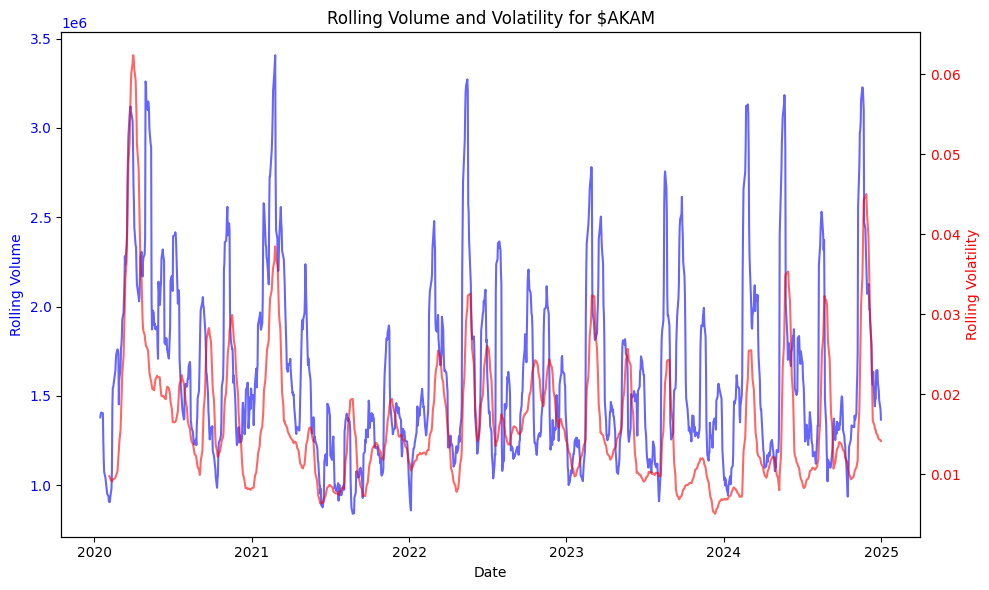

In [28]:
# Additional visualization: Rolling Volume and Rolling Volatility for an example stock
stock_data = all_stock_data[12]
rolling_volume = stock_data['Volume'].rolling(window=10).mean()
rolling_volatility = stock_data['Volatility'].rolling(window=10).mean()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(stock_data.index, rolling_volume, color='blue', alpha=0.6)
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Volume', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(stock_data.index, rolling_volatility, color='red', alpha=0.6)
ax2.set_ylabel('Rolling Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f"Rolling Volume and Volatility for ${ticker_list[12]}")
fig.tight_layout()
plt.show()

### LSTM Model for Predicting Volatility
In
the
next
part, we
build
an
LSTM
model
to
predict
the
volatility
for one of the stocks based on its historical volatility series.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Select one stock’s volatility data for prediction;
# Here we use the first stock in our all_stock_data list. Ensure there are no NaN values.
stock_data = all_stock_data[0].copy()
df = stock_data[['Volatility']].dropna()
df.reset_index(drop=True, inplace=True)

# Normalize the volatility data to the [0,1] range.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)


# Define a function to create sequences from the data.
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


# Set a window size; here we use the past 10 days to predict the next day’s volatility.
window_size = 10
X, y = create_sequences(scaled_data, window_size)

# Split the sequences into training and test sets (80% training, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 987, Test samples: 247


In [30]:
# Define the LSTM model.
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    LSTM(25, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/Users/anish/STUDY/Spring 25/F. Data Science/Stock-Volatility/.venv1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Set up early stopping to prevent overfitting.
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model.
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=100,
                    batch_size=16,
                    callbacks = [es],
                    verbose=1)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0027
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

In [32]:
# Evaluate the model on the test set.
test_loss = model.evaluate(X_test, y_test)
print("Test loss (MSE):", test_loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Test loss (MSE): 0.005697848740965128


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


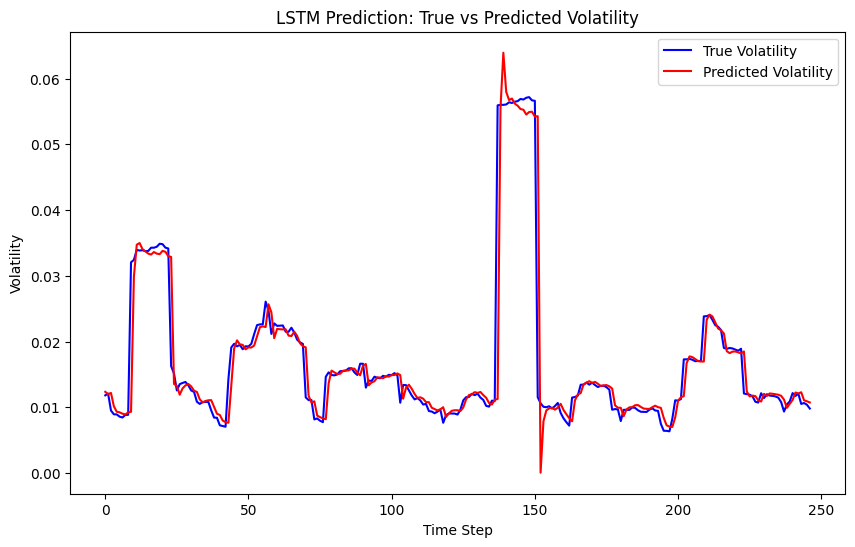

In [36]:
# Make predictions on the test set.
y_pred = model.predict(X_test)

# Inverse-transform the scaled predictions and true values.
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot the true volatility versus the predicted volatility.
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='True Volatility', color='blue')
plt.plot(y_pred_inv, label='Predicted Volatility', color='red')
plt.title("LSTM Prediction: True vs Predicted Volatility")
plt.xlabel("Time Step")
plt.ylabel("Volatility")
plt.legend()
plt.show()

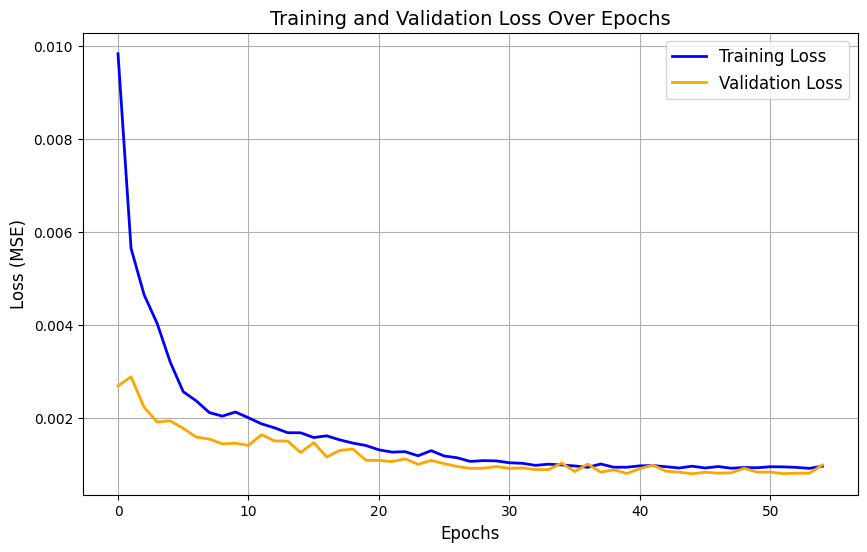

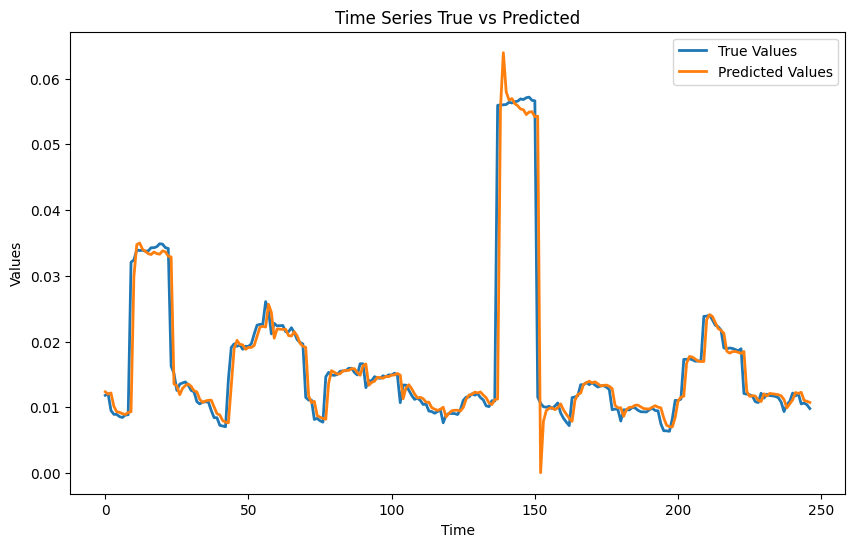

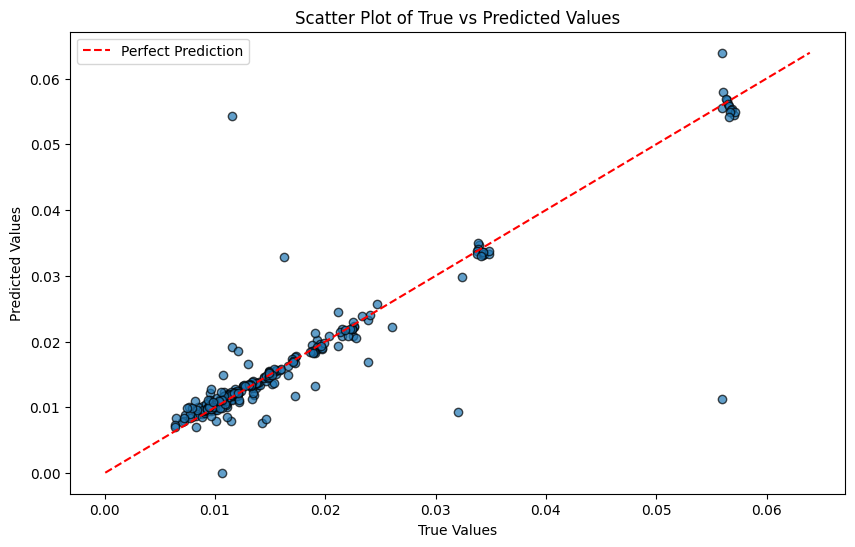

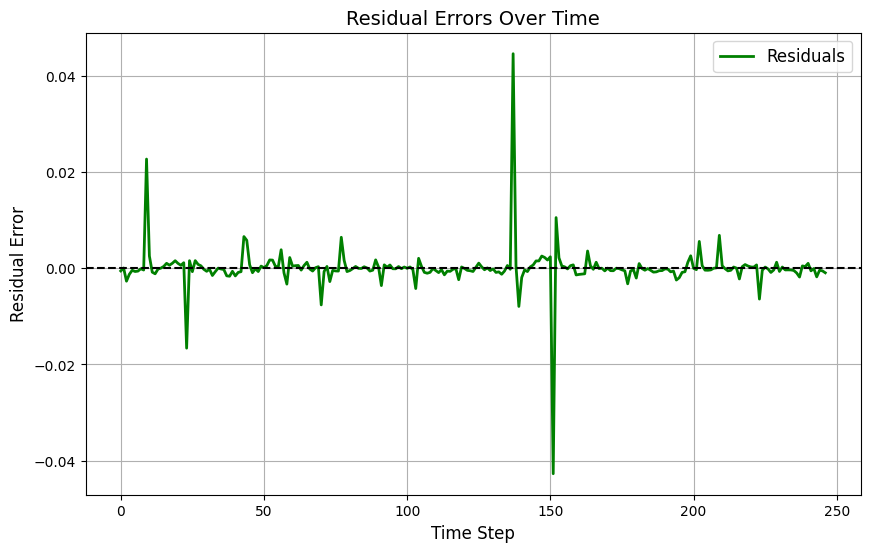

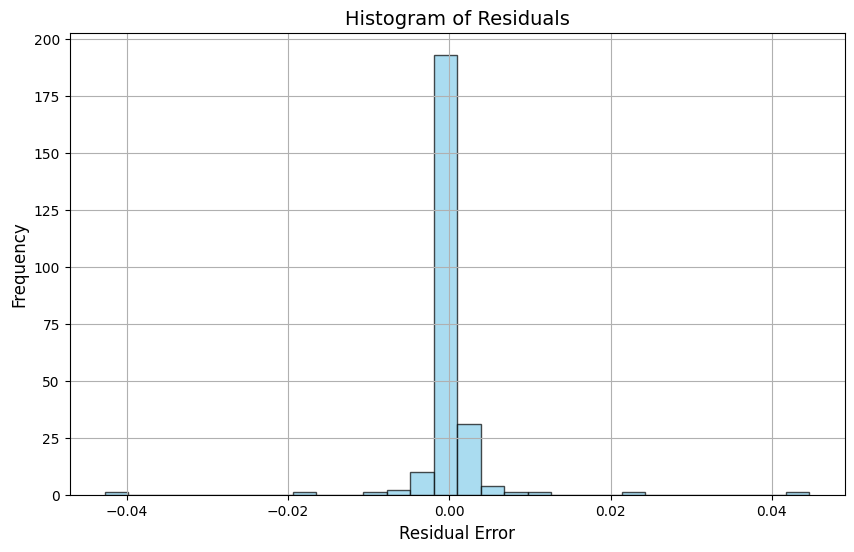

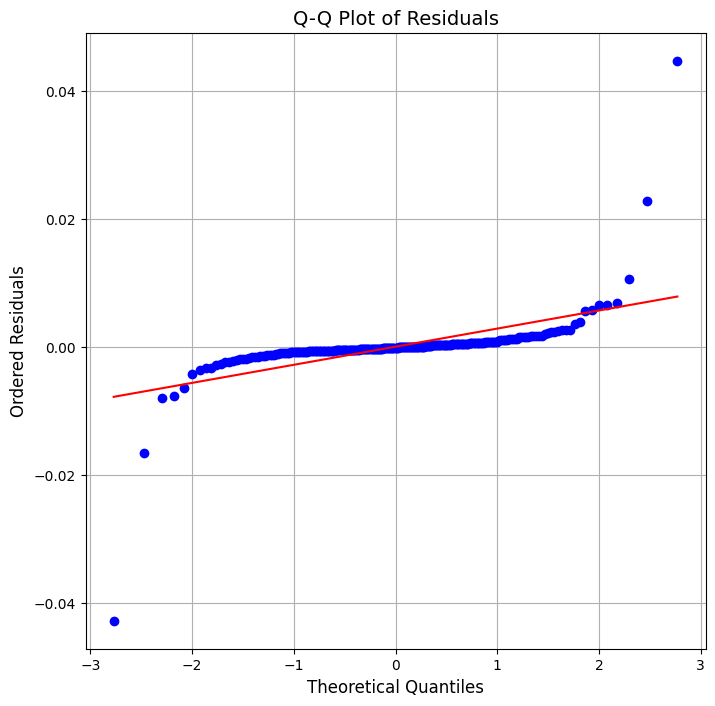

NameError: name 'plot_acf' is not defined

<Figure size 1000x600 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
from scipy import stats


# ------------------------------------------------------
# 1. Plotting Training and Validation Loss History
# ------------------------------------------------------
def plot_loss_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    plt.title("Training and Validation Loss Over Epochs", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss (MSE)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


# Call the function with your history object
plot_loss_history(history)


# ------------------------------------------------------
# 2. Plotting True vs Predicted Volatility Over Time
# ------------------------------------------------------
def plot_true_vs_pred(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='True Volatility', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted Volatility', color='red', linewidth=2)
    plt.title("True vs. Predicted Volatility", fontsize=14)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Volatility", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

def plot_true_vs_pred(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label="True Values", linewidth=2)
    plt.plot(y_pred, label="Predicted Values", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title("Time Series True vs Predicted")
    plt.legend()
    plt.show()

# Use your inverse-transformed values
plot_true_vs_pred(y_test_inv, y_pred_inv)

def scatter_true_vs_pred(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Scatter Plot of True vs Predicted Values")
    # Plot a diagonal line for reference
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
    plt.legend()
    plt.show()

scatter_true_vs_pred(y_test_inv, y_pred_inv)

# 4. Plotting Residual Errors Over Time
def plot_residuals_over_time(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='green', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title("Residual Errors Over Time", fontsize=14)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Residual Error", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


# Call the function using your inverse-transformed true and predicted values
plot_residuals_over_time(y_test_inv, y_pred_inv)


# 5. Histogram of Residuals
def plot_residuals_histogram(y_true, y_pred, bins=30):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=bins, color='skyblue', alpha=0.7, edgecolor='black')
    plt.title("Histogram of Residuals", fontsize=14)
    plt.xlabel("Residual Error", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True)
    plt.show()


plot_residuals_histogram(y_test_inv, y_pred_inv)


# 6. Q-Q Plot of Residuals
#
def plot_qq_residuals(y_true, y_pred):
    # Ensure both y_true and y_pred are 1-dimensional
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    residuals = y_true - y_pred
    plt.figure(figsize=(8, 8))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals", fontsize=14)
    plt.xlabel("Theoretical Quantiles", fontsize=12)
    plt.ylabel("Ordered Residuals", fontsize=12)
    plt.grid()
    plt.show()


plot_qq_residuals(y_test_inv, y_pred_inv)


# 7. Autocorrelation Plot for Residuals
def plot_residuals_autocorrelation(y_true, y_pred, lags=40):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plot_acf(residuals, lags=lags, alpha=0.05)
    plt.title("Autocorrelation of Residuals", fontsize=14)
    plt.xlabel("Lag", fontsize=12)
    plt.grid(True)
    plt.show()

plot_residuals_autocorrelation(y_test_inv, y_pred_inv)



# 8. Rolling Statistics (Mean & Std) for Residuals
def plot_rolling_stats(y_true, y_pred, window=50):
    residuals = pd.Series(y_true - y_pred)
    rolling_mean = residuals.rolling(window=window).mean()
    rolling_std = residuals.rolling(window=window).std()

    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label="Residuals", color='gray', alpha=0.5)
    plt.plot(rolling_mean, label=f"Rolling Mean (window={window})", color='blue', linewidth=2)
    plt.plot(rolling_std, label=f"Rolling Std Dev (window={window})", color='red', linewidth=2)
    plt.title("Rolling Mean and Standard Deviation of Residuals", fontsize=14)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Error Value", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


plot_rolling_stats(y_test_inv, y_pred_inv, window=50)


# 9. Density Plot (KDE) for Prediction Errors
def plot_kde_errors(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.kdeplot(residuals, shade=True, color="purple")
    plt.title("Density Plot (KDE) of Prediction Errors", fontsize=14)
    plt.xlabel("Residual Error", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True)
    plt.show()


plot_kde_errors(y_test_inv, y_pred_inv)

